In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

C:\Users\JeongYeong\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
bins = 20
dx = 1 / (bins - 1)
inf = 1000
num_model = 1
#h_bar = 6.63 * 10**(-34)
#m = 9.11 * 10**(-31)
#C = -h_bar**2 / (2*m)
C = -1
A = C / dx**2
#A = tf.constant(A, shape=[1, bins+2])


pot = np.zeros([1, bins])
pot[0, 0] = inf; pot[0, -1] = inf;
pot = tf.constant(pot, shape=[1, bins], dtype=tf.float32, name='potential')
train = tf.placeholder(tf.float32, [1, bins+2], name='train')

In [16]:
def make_var(number, bins):
    w = tf.Variable(tf.random_normal([bins+2, bins+2]), name='weight%d'%(number))
    b = tf.Variable(tf.random_normal([1, bins+2]), name='bias%d'%(number))
    return w, b

def cal_model(x, w, b):
    return tf.add(tf.matmul(x, w), b)

def cal_hamiltonian(psi, pot, dx, A):
    #psi1 = tf.concat([tf.slice(psi, [0, 1], [1, bins+1]), [[0.]]], 1)
    #psi2 = tf.concat([[[0.]], tf.slice(psi, [0, 0], [1, bins+1])], 1)
    psi1 = tf.slice(psi, [0, 0], [1, bins])
    psi2 = tf.slice(psi, [0, 2], [1, bins])
    psi0 = tf.slice(psi, [0, 1], [1, bins])
    dy2 = tf.subtract(2 * psi0, tf.add(psi1, psi2))
    H = tf.add(tf.multiply(psi0, pot), A * dy2)
    return H, psi0

def cal_variance(psi, E):
    diff = tf.square(tf.subtract(E, psi))
    return tf.reduce_mean(diff)

def integrate_simps(f, bins, dx):
    if (bins-1)%3 == 0:
        ff = f[0, 1:] # f1 to fend
        ff = tf.transpose(tf.reshape(ff, [-1, 3]))
        row12 = tf.reduce_sum(ff[0: 2])
        row3 = tf.reduce_sum(ff[2])
        ssum = tf.add(2 * row3, 3 * row12)
        ssum = 3/8 * dx * tf.add(f[0, 0], tf.subtract(ssum, 2 * f[0, -1]))
    else:
        cc = [1, 4, 2]
        n = bins - (bins-1)%3
        ff = tf.slice(f, [0, 0], [1, n])
        ssum = integrate_simps(ff, n, dx)
        for i in range(bins - n + 1):
            ssum = tf.add(ssum, f[0, -(i+1)] * cc[i] * dx/3)
    return ssum

In [17]:
for i in range(num_model):
    w_temp, b_temp = make_var(i, bins)
    exec('w%d = w_temp'%(i))
    exec('b%d = b_temp'%(i))
    
    if i == 0:
        psi = cal_model(train, w0, b0)
    else:
        exec('psi = cal_model(psi, w%d, b%d)'%(i, i))

psi = psi / tf.sqrt(tf.reduce_sum(psi))
H, psi0 = cal_hamiltonian(psi, pot, dx, A) # resize psi (delete both sides end points)
#var = cal_variance(psi, E)
#energy = integrate_simps(tf.multiply(psi2, H), bins, dx)
energy = tf.reduce_sum(tf.multiply(H, psi0))
#cost = tf.add(energy**2, psi2[0, 0]**2 + psi2[0, -1]**2, name='cost')
cost = tf.square(energy, name='cost')

In [18]:
cost

<tf.Tensor 'cost_2:0' shape=() dtype=float32>

In [19]:
opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

In [20]:
#sum_var = tf.summary.scalar('variance', var)
sum_cost = tf.summary.scalar('cost', cost)
#sum_weight = tf.summary.histogram('weight0', w0)
#sum_bias = tf.summary.histogram('bias0', b0)
#sum_energy = tf.summary.histogram('energy', energy) 

In [21]:
directory = './new_1'
with tf.Session() as sess:
    writer = tf.summary.FileWriter(directory)
    writer.add_graph(sess.graph)
    
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    
    itr = 10000
    init = np.random.normal(size=[1, bins+2])
    
    for i in tqdm_notebook(range(itr)):
        summary, _ = sess.run([merged, opt], feed_dict={train: init})
        writer.add_summary(summary, global_step=i)
    
    H_val, psi_val, pot_val, w_val, b_val = sess.run([H, psi0, pot, w0, b0], feed_dict={train: init})
    

InvalidArgumentError: You must feed a value for placeholder tensor 'train' with dtype float and shape [1,22]
	 [[Node: train = Placeholder[dtype=DT_FLOAT, shape=[1,22], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'train', defined at:
  File "C:\Users\JeongYeong\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\JeongYeong\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\JeongYeong\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\JeongYeong\Anaconda3\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\JeongYeong\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\tornado\ioloop.py", line 759, in _run_callback
    ret = callback()
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-43a83897df21>", line 16, in <module>
    train = tf.placeholder(tf.float32, [1, bins+2], name='train')
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1734, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 5927, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\JeongYeong\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'train' with dtype float and shape [1,22]
	 [[Node: train = Placeholder[dtype=DT_FLOAT, shape=[1,22], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [14]:
psi_val

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

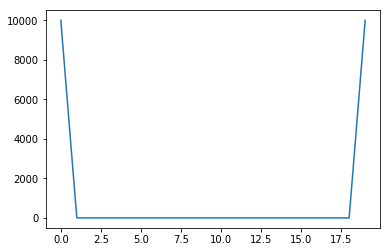

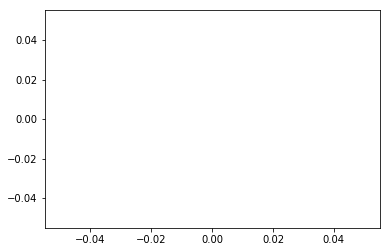

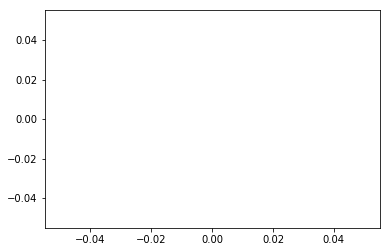

In [12]:
plt.plot(pot_val[0]); plt.show()
plt.plot(psi_val[0]); plt.show()
plt.plot(H_val[0]); plt.show()

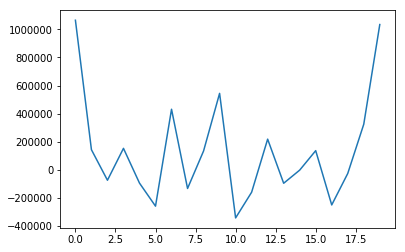

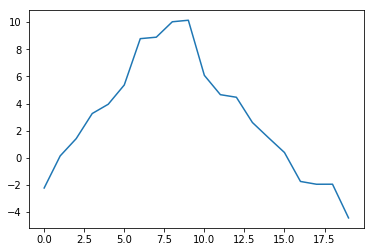

In [20]:
plt.plot(H_val[0])
plt.show()
plt.plot(psi_val[0])
plt.show()

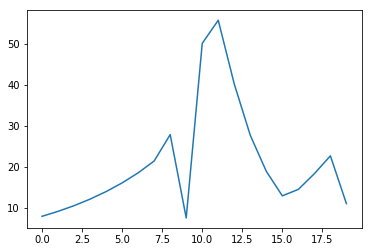

In [14]:
plt.plot(abs(psi_val[0]))

In [14]:
aa = np.arange(8).reshape(4, 2)
aa = tf.constant(aa, shape=[4, 2])
with tf.Session() as sess:
    print(sess.run(tf.reduce_sum(aa)))

28


In [ ]:
tf.int